In [ ]:
import pandas as pd

orders = pd.read_csv('/content/ab_orders.csv')
visits = pd.read_csv('/content/ab_visits.csv')

orders.head(), visits.head()

(    order_id                  state       rub_fee   visit_id
 0  2567621.0   canceled_by_attendee   8537.573340  949717496
 1  2562838.0                   held   3526.946108  948593403
 2  2595145.0                cleared  15851.047378  957724672
 3  2543617.0                cleared   2292.514970  943946417
 4  2543557.0  confirmed_by_attendee   1058.083832  943917941,
                               feature_id                                value  \
 0  ab_listing_activity_mobile_app_banner                                false   
 1  ab_listing_activity_mobile_app_banner  growth_catalog_improving_navigation   
 2  ab_listing_activity_mobile_app_banner                                 true   
 3  ab_listing_activity_mobile_app_banner                                false   
 4  ab_listing_activity_mobile_app_banner                                false   
 
                    started_at                         visitor_token  \
 0  2024-11-10 01:09:05.941117  52cff668-ae02-4780-91b7-88ffd

In [ ]:
# Проверка на пропуски
print(orders.isnull().sum())
print(visits.isnull().sum())

order_id    0
state       0
rub_fee     0
visit_id    0
dtype: int64
feature_id       0
value            0
started_at       0
visitor_token    0
visit_id         0
url              0
variation_id     0
views_amount     0
dtype: int64
order_id    float64
state        object
rub_fee     float64
visit_id      int64
dtype: object
feature_id        object
value             object
started_at        object
visitor_token     object
visit_id           int64
url               object
variation_id       int64
views_amount     float64
dtype: object


In [ ]:
# Проверка типов данных
print(orders.dtypes)
print(visits.dtypes)

order_id    float64
state        object
rub_fee     float64
visit_id      int64
dtype: object
feature_id        object
value             object
started_at        object
visitor_token     object
visit_id           int64
url               object
variation_id       int64
views_amount     float64
dtype: object


In [ ]:
# Проверка дублей
print(f"Дубликаты в orders: {orders.duplicated().sum()}")
print(f"Дубликаты в visits: {visits.duplicated().sum()}")

Дубликаты в orders: 0
Дубликаты в visits: 8426


In [ ]:
# Так как в visits есть дубликаты, то будем брать последний визит и будем суммировать просмотры
visits = visits.groupby('visit_id', as_index=False).agg({
    'feature_id': 'first',
    'value': 'first',
    'started_at': 'max',  # Берём последний визит
    'visitor_token': 'first',
    'url': 'first',
    'variation_id': 'first',
    'views_amount': 'sum'  # Суммируем просмотры
})

In [ ]:
# Проверка наличия дублей после агрегирования
print(f"Дубликаты в visits: {visits.duplicated().sum()}")

Дубликаты в visits: 0


In [ ]:
# Объединяем таблицы по visit_id
df = visits.merge(orders, on="visit_id", how="left")

# Заполним столбец rub_fee 0 вместо null значений, где не было заказов
df['rub_fee'] = df['rub_fee'].fillna(0)

# Проверка структуры
df.head()

,visit_id,feature_id,value,started_at,visitor_token,url,variation_id,views_amount,order_id,state,rub_fee
0,943234725,ab_listing_activity_mobile_app_banner,false,2024-10-24 00:00:05.194580,1e089bb4-baec-4774-be09-4676402d3f49,/ru/kaliningrad,0,0.0,NaN,NaN,0.0
1,943234758,ab_listing_activity_mobile_app_banner,true,2024-10-24 00:00:12.646760,c2957a2a-b6ac-430b-82e0-369a5c788bdf,https://www.sputnik8.com/ru/st-petersburg/acti...,1,42.0,NaN,NaN,0.0
2,943234768,ab_listing_activity_mobile_app_banner,false,2024-10-24 00:00:16.248144,d1ac47a8-0fd6-434e-8119-ad92589f1d8b,/ru/tula/category/razvlecheniya,0,0.0,NaN,NaN,0.0
3,943234774,ab_listing_activity_mobile_app_banner,false,2024-10-24 00:00:17.798008,8ad130b9-e45e-4d16-b057-91288764fd3a,https://www.sputnik8.com/ru/moscow/activities/...,0,1.0,NaN,NaN,0.0
4,943234783,ab_listing_activity_mobile_app_banner,true,2024-10-24 00:00:19.648046,2276ea8e-72fb-45cf-a50f-326c52a8d852,/ru/st-petersburg/category/zakrytie-fontanov-v...,1,0.0,NaN,NaN,0.0


# **Расчёт основных метрик**

In [ ]:
# Конверсия в заказ
conversion = df.groupby("value")['order_id'].count() / df.groupby("value")['visit_id'].count()
print(conversion)

value
false                                  0.029780
growth_catalog_improving_navigation    0.029823
true                                   0.028418
dtype: float64


In [ ]:
# Конверсия в успешный заказ, то есть статусы cleared и held
df['success'] = df['state'].isin(['cleared', 'held']).astype(int)
conversion_success = df.groupby("value")['success'].mean()
print(conversion_success)

value
false                                  0.016180
growth_catalog_improving_navigation    0.015575
true                                   0.016363
Name: success, dtype: float64


In [ ]:
# Средний чек
rub_fee_avg = df.groupby("value")['rub_fee'].mean()
print(rub_fee_avg)

value
false                                  155.209166
growth_catalog_improving_navigation    155.380263
true                                   148.759408
Name: rub_fee, dtype: float64


In [ ]:
# Глубина просмотра
views_avg = df.groupby("value")['views_amount'].mean()
print(views_avg)

value
false                                  2.947243
growth_catalog_improving_navigation    2.639780
true                                   5.522378
Name: views_amount, dtype: float64


# **Расчёт p-value для полученных метрик**

In [37]:
# Z-тест для конверсии
from statsmodels.stats.proportion import proportions_ztest

# Количество заказов и визитов по группам
orders_test = df[df['value'] == 'growth_catalog_improving_navigation']['order_id'].count()
visits_test = df[df['value'] == 'growth_catalog_improving_navigation']['visit_id'].count()

orders_control = df[df['value'] == 'false']['order_id'].count()
visits_control = df[df['value'] == 'false']['visit_id'].count()

# Z-тест
z_stat, p_val = proportions_ztest([orders_test, orders_control], [visits_test, visits_control])
print(f'Z-stat: {z_stat:.2f}, p-value: {p_val:.4f}')

Z-stat: 0.10, p-value: 0.9196


In [38]:
# T-тест для среднего
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    df[df['value'] == 'growth_catalog_improving_navigation']['rub_fee'],
    df[df['value'] == 'false']['rub_fee'],
    equal_var=False
)

print(f'T-stat: {t_stat:.2f}, p-value: {p_value:.4f}')

T-stat: 0.05, p-value: 0.9614


In [39]:
# U-тест (критерий Манна-Уитни, так как рспределение не всегда равномерное) для глубины просмотра
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(
    df[df['value'] == 'growth_catalog_improving_navigation']['views_amount'],
    df[df['value'] == 'false']['views_amount']
)

print(f'U-stat: {u_stat}, p-value: {p_value:.4f}')

U-stat: 52830890421.0, p-value: 0.0000


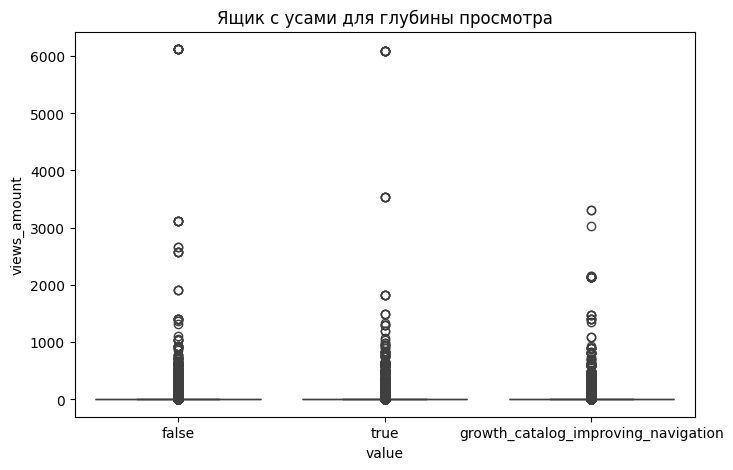

In [ ]:
# Проверка корректности использования критерия Манна-Уитни
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot глубины просмотра
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='value', y='views_amount')
plt.title('Ящик с усами для глубины просмотра')
plt.show()